# Lab 6 by Boying Li (boylil-3)

Some notes taken from the paper:

The spectral radius ρ(W) of a matrix W is the largest absolute value of its eigenvalues. It scales the matrix W. In practice ρ(W) should be selected to maximize the performance, with the value 1 serving as an initial reference point.

Input scaling determines how nonlinear the reservoir responses are. For very linear tasks Win
should be small, letting units operate around the 0 point where their activation tanh(·) is virtually
linear. For large Win, the units will get easily saturated close to their 1 and −1 values, acting in
a more nonlinear, binary switching manner.

# Implement ESN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import pandas as pd

In [20]:
class ESN:
  '''
  step 1-4 text is copied from the paper
  '''
  def __init__(self, in_size, out_size, reservoir_size, rho_scale=1.0, input_scale=1.0):

    self.in_size = in_size
    self.out_size = out_size
    self.reservoir_size = reservoir_size

    # 1.generate a large random reservoir RNN
    self.W_in = np.random.uniform(-1, 1, (reservoir_size, in_size+1))*input_scale #in_size+1 add bias input neuron
    self.W_out = np.zeros((out_size, reservoir_size))

    self.W = np.random.uniform(-1, 1, (reservoir_size, reservoir_size))
    self.W = self.W * (rho_scale/max(np.abs(np.linalg.eigvals(self.W))))

    self.x = np.zeros((reservoir_size,1))



  # 2. run it using the training input u(n) and collect the corresponding reservoir activation states x(n)
  # From paper: The typical update equations are x(n) = tanh(W_in[1;u(n)]+Wx(n-1))
  def run(self, input):
    # input_bias = np.append(input, 1)
    input_bias = np.vstack((1,input))
    self.x = np.tanh(np.dot(self.W_in, input_bias) + np.dot(self.W, self.x))
    return self.x


  # 3. compute the linear readout weights Wout from the reservoir using linear regression, minimizing the MSE between y(n) and ytarget(n);
  # only W_out will be updated during training, W_in and W will remain fixed
  def train(self, input, Y, discard_len, reg=1e-6):
    reservoir_states = np.zeros((1+self.in_size + self.reservoir_size, len(input)-discard_len))
    for t in range(len(input)):
      self.x = self.run(input[t])
      if t >= discard_len:
        reservoir_states[:,t-discard_len] = np.vstack((1,input[t], self.x))[:,0]

    # print('x', self.x.shape)
    # print('reservoir_states', reservoir_states.shape)
    # print('reservoir_states.T', reservoir_states.T.shape)
    # print('Y', Y.shape)
    # use scipy.linalg.solve to solve the linear regression:
    self.W_out = linalg.solve(np.dot(reservoir_states, reservoir_states.T) + reg*np.eye(reservoir_size+1 + self.in_size), np.dot(reservoir_states,Y.T)).T


  # use the trained network on new input data u(n) computing y(n) by employing the trained output weights Wout
  # From paper: The linear readout layer is defined as y(n) = Wout[1; u(n); x(n)]
  def predict(self, input):
    predictions = np.zeros((self.out_size, len(input)))
    for t in range(len(input)):
      self.x = self.run(input[t])
      prediction = np.dot(self.W_out, np.vstack((1,input[t], self.x)))
      predictions[:t] = prediction
    return predictions

  def test(self, test_data, Y_test):
    ys = np.zeros((self.out_size, len(test_data)))
    test_input = test_data[0]
    for t in range(len(test_data)):
      x = self.run(test_input)
      y = np.dot(self.W_out, np.vstack((1,test_input,x)))
      ys[:,t] = y
      # In the operating phase, the network acts as the generator of the signal
      # (thanks to trained readout matrix) feeding its previous prediction (at time
      # n−1) back to the reservoir.
      test_input = y


    mse = sum(np.square(test_data - ys[0])) / len(test_data)
    return ys, mse








# Modeling of dynamic systems with ESN

# Sinusoidal signal

In [ ]:
def sinusoidal(n):
    x = np.linspace(0,n,n)
    y = 0.5*np.sin(x/4)
    return x, y

n = 4000
len_train = 3000
len_test = 1000
timestep, sin_input = sinusoidal(n)

# Initialize ESN
input_size = 1
reservoir_size = 1000
output_size = 1
discard_len = 1000
sin_train_x = sin_input[:len_train]
sin_train_y = sin_input[discard_len+1:len_train+1]

sin_test_x = sin_input[len_train:]
sin_test_y = sin_input[len_train+1:]

In [ ]:
esn = ESN(input_size, output_size, reservoir_size, 0.8, 0.2)
esn.train(sin_train_x, sin_train_y, 1000)

predicted_test, test_mse = esn.test(sin_test_x, sin_test_y)

x (1000, 1)
reservoir_states (1002, 2000)
reservoir_states.T (2000, 1002)
Y (2000,)


In [ ]:
predicted_test.shape, test_mse

((1, 1000), 0.007800684122664455)

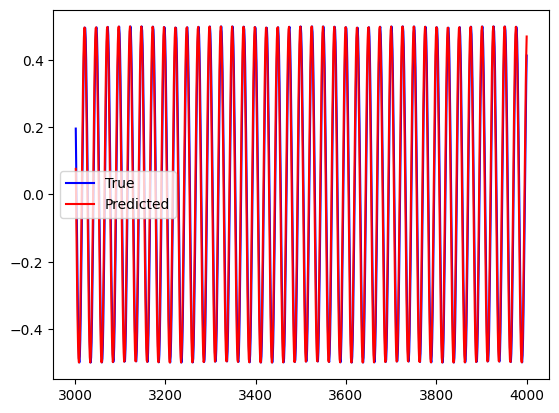

In [ ]:
plt.plot(timestep[len_train+1:], sin_test_y, 'b', label='True')
plt.plot(timestep[len_train+1:], predicted_test[0,1:], 'r', label='Predicted')
plt.legend()
plt.show()

# Mackey-glass

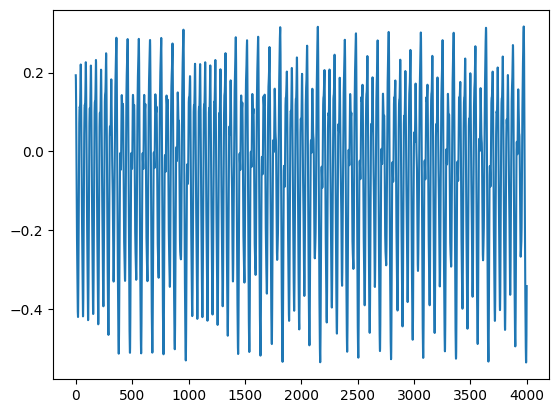

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# check for intuition at http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1
    a=10
    delay=100 # will cut these initial steps

    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a)   )  ) - gamma*y[t]
        y=np.append(y, current)

    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh

    return y[tau+delay:length+delay+tau] # return the last length elements


length=4000 # duration of the series
tau=17 # delay in the equation

y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

In [ ]:
n = 4000
len_train = 3000
len_test = 1000
MG_input = mackey_glass(tau, length)

# Initialize ESN
input_size = 1
reservoir_size = 1000
output_size = 1
discard_len = 1000

MG_train_x = MG_input[:len_train]
MG_train_y = MG_input[discard_len+1:len_train+1]

MG_test_x = MG_input[len_train:]
MG_test_y = MG_input[len_train+1:]

In [ ]:
esn = ESN(input_size, output_size, reservoir_size, 0.8, 0.2)
esn.train(MG_train_x, MG_train_y, 1000)

predicted_test, test_mse = esn.test(MG_test_x, MG_test_y)

x (1000, 1)
reservoir_states (1002, 2000)
reservoir_states.T (2000, 1002)
Y (2000,)


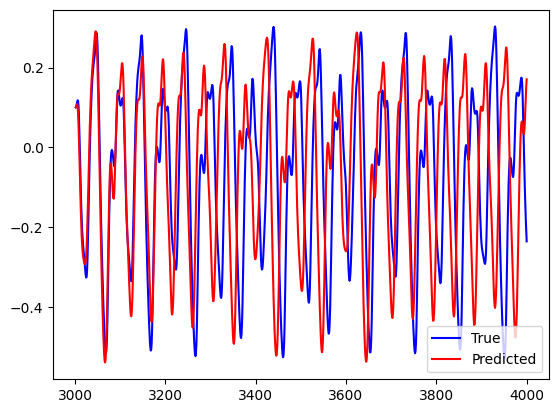

In [ ]:
plt.plot(timestep[len_train+1:], MG_test_y, 'b', label='True')
plt.plot(timestep[len_train+1:], predicted_test[0,1:], 'r', label='Predicted')
plt.legend()
plt.show()

# Time-series	classification with	ESN

In [136]:
class Classify(ESN):
  def __init__(self, in_size, out_size, reservoir_size, rho_scale, input_scale):
    super().__init__(in_size, out_size, reservoir_size, rho_scale, input_scale)


  def train(self, input, Y, reg=1e-6):
    reservoir_states = np.zeros((1+self.out_size + self.reservoir_size, len(input)))
    for row in range(len(input)):
      signal = input[row,:]

      for t in range(len(signal)):
        self.x = self.run(signal[t])
        #reservoir_states[:,row] = np.vstack((1,signal[t], self.x))[:,0]
      # Save the last state of the reservoir
      reservoir_states[:,row] = np.vstack((1,Y[row], self.x))[:,0]

    # use scipy.linalg.solve to solve the linear regression:
    self.W_out = linalg.solve(np.dot(reservoir_states, reservoir_states.T) + reg*np.eye(reservoir_size + 1 + self.out_size), np.dot(reservoir_states,Y)).T


  def test(self, test_data, Y_test):
    predictions = []
    correct_count = 0
    for row in range(len(test_data)):
      signal = test_data[row,:]
      y = np.zeros((1,16))
      for t in range(len(signal)):
        x = self.run(signal[t])
        y = np.dot(self.W_out, y, x)


      # In the operating phase, the network acts as the generator of the signal
      # (thanks to trained readout matrix) feeding its previous prediction (at time
      # n−1) back to the reservoir.
      prediction = np.argmax(y)
      print(prediction)
      predictions.append(prediction)
      if prediction == Y_test[row]:
        correct_count += 1
    acc = correct_count/len(Y_test)

    return predictions, acc

In [95]:
train_path = 'SwedishLeaf_TRAIN.tsv'
train_data = pd.read_csv(train_path, header=None, sep='\t')

test_path = 'SwedishLeaf_TEST.tsv'
test_data = pd.read_csv(test_path, header=None, sep='\t')

In [96]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,4,1.524750,1.53812,1.410790,1.244400,1.03947,0.868676,0.664257,0.489801,0.268549,...,0.857708,0.760649,0.521033,0.362176,0.561489,0.741670,0.95521,1.09676,1.32531,1.484260
1,11,2.214930,2.05051,1.842350,1.635900,1.43259,1.285370,1.143260,1.006700,0.834105,...,0.597998,0.712422,0.876184,1.000530,1.143260,1.339930,1.54185,1.75360,1.96243,2.167350
2,13,1.872010,1.72637,1.573640,1.396900,1.25221,1.083760,0.955383,0.796125,0.718198,...,0.543164,0.660779,0.731471,0.865444,0.978358,1.158070,1.30960,1.49456,1.65084,1.839430
3,4,1.731019,1.70220,1.553009,1.387209,1.14458,0.951378,0.733035,0.559737,0.853391,...,-0.157605,0.102225,0.317060,0.569536,0.786314,0.998449,1.21775,1.33880,1.58373,1.688559
4,13,1.842670,1.74943,1.593560,1.420510,1.26840,1.118720,0.972792,0.832494,0.711975,...,0.546884,0.635829,0.755926,0.895839,1.041540,1.188390,1.33839,1.51080,1.66561,1.822640


In [97]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 129 entries, 0 to 128
dtypes: float64(128), int64(1)
memory usage: 504.0 KB


In [98]:
train_x = train_data.iloc[:, 1:]
train_y = train_data.iloc[:, [0]]

test_x = test_data.iloc[:, 1:]
test_y = test_data.iloc[:, [0]]

In [99]:
def onehot(labels):

  labels = np.array(labels)
  num_classes = np.max(labels)+1

  onehot_label = np.zeros((labels.shape[0], num_classes))
  for i, row in enumerate(onehot_label):
    onehot_label[i, labels[i]] = 1

  return onehot_label

In [138]:
# Initialize ESN
input_size = 1
reservoir_size = 800
output_size = 15
discard_len = 0
esn = Classify(input_size, output_size, reservoir_size, 0.99, 0.25)

In [101]:
train_x = np.array(train_x)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [102]:
train_y.min(),train_y.max()

(0    1
 dtype: int64,
 0    15
 dtype: int64)

In [103]:
onehot_train_label = onehot(train_y)
onehot_train_label.shape

(500, 16)

In [139]:
esn.train(train_x, onehot_train_label)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 16

In [ ]:
predictions, test_accuracy = esn.test(test_x, test_y)

In [105]:
esn.W_out.shape

(16, 802)

In [134]:
test_accurcy

0.4576

# Repeat the experiment for 10 different random initializations of ESNs

In [111]:
def multiple_run(nr):
  total_acc = []
  for i in range(nr):
    esn = Classify(input_size, output_size, reservoir_size, 0.99, 0.25)
    esn.train(train_x, onehot_train_label)
    _, test_accuracy = esn.test(test_x, test_y)
    total_acc.append(test_accuracy)

  return np.mean(total_acc)
avg_run_acc = multiple_run(10)
print('the average accuracy of the predictions obtained from 10 random ESNs is:', avg_run_acc)

the average accuracy of the predictions obtained from 10 random ESNs is: 0.50816
